# Model Building/Testing

In [14]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix


# import our modules
from modules.utils import *

#### Load data

In [4]:
train = pd.read_csv('dataset/train.csv')
test  = pd.read_csv('dataset/test.csv')

# get featrues and labels
X_train, y_train = train.iloc[:, :-1], train['ACTIVITY']
X_test,  y_test = test.iloc[:, :-1], test['ACTIVITY']

X_train.head(10)

,BODY_ACC_X_STD,BODY_ACC_X_MEAN,BODY_ACC_X_MAD,BODY_ACC_X_MAX,BODY_ACC_X_MIN,BODY_ACC_X_IQR,BODY_ACC_X_CORRELATION-1,BODY_ACC_X_CORRELATION-2,BODY_ACC_X_ACORR-PEAKS-MEAN,BODY_ACC_X_ACORR-PEAK-VALUE-0,...,TOTAL_ACC_Z_FFT-PEAK-VALUE-0,TOTAL_ACC_Z_FFT-PEAK-VALUE-1,TOTAL_ACC_Z_FFT-PEAK-VALUE-2,TOTAL_ACC_Z_FFT-PEAK-VALUE-3,TOTAL_ACC_Z_FFT-PEAK-VALUE-4,TOTAL_ACC_Z_FFT-PEAK-DOMAIN-0,TOTAL_ACC_Z_FFT-PEAK-DOMAIN-1,TOTAL_ACC_Z_FFT-PEAK-DOMAIN-2,TOTAL_ACC_Z_FFT-PEAK-DOMAIN-3,TOTAL_ACC_Z_FFT-PEAK-DOMAIN-4
0,0.002941,0.002269,0.002025,0.010810,-0.004294,0.004812,0.374934,0.433372,0.001125,0.001205,...,0.000440,0.000781,0.000479,0.000556,0.000576,1.190476,3.174603,3.968254,4.761905,5.952381
1,0.001981,0.000174,0.000110,0.005251,-0.006706,0.001970,-0.011562,-0.071672,0.000038,0.000031,...,0.000669,0.000660,0.000661,0.000582,0.000858,0.793651,1.984127,2.777778,3.968254,5.158730
2,0.002908,0.000428,0.000627,0.008167,-0.010483,0.003138,-0.121905,-0.179492,0.000097,0.000255,...,0.001235,0.000832,0.000626,0.000790,0.001252,0.793651,1.587302,2.380952,4.365079,5.952381
3,0.002678,0.000329,0.000269,0.008167,-0.010483,0.003128,-0.301393,-0.360048,0.000181,0.000304,...,0.000903,0.000749,0.000358,0.000727,0.000890,1.190476,1.984127,3.571429,4.365079,5.952381
4,0.002015,-0.000195,-0.000144,0.005650,-0.006847,0.002622,-0.152752,-0.188102,0.000052,0.000060,...,0.000580,0.000890,0.000660,0.000693,0.000565,1.190476,2.777778,3.968254,4.761905,5.952381
5,0.002276,-0.000078,-0.000182,0.005650,-0.006847,0.002883,-0.206476,-0.149615,0.000045,-0.000060,...,0.000923,0.001155,0.001041,0.000690,0.000885,1.587302,2.777778,3.571429,5.555556,7.142857
6,0.002409,0.000387,0.000461,0.006637,-0.005558,0.003317,-0.093299,-0.134364,0.000103,0.000155,...,0.000811,0.001078,0.001735,0.000898,0.000974,1.190476,2.777778,3.571429,6.746032,9.126984
7,0.002527,-0.000030,-0.000261,0.006637,-0.006030,0.003928,-0.158534,-0.016404,0.000093,0.000120,...,0.000893,0.000659,0.001169,0.000670,0.000786,1.587302,2.380952,3.571429,5.158730,6.349206
8,0.002278,-0.000058,-0.000261,0.006897,-0.006030,0.002976,-0.161664,-0.032960,0.000111,0.000138,...,0.001123,0.000448,0.001132,0.000402,0.000287,1.190476,2.777778,5.158730,5.952381,6.746032
9,0.003095,0.000620,0.000495,0.007276,-0.009268,0.003705,-0.173019,-0.444580,0.000278,0.000231,...,0.000880,0.001386,0.001759,0.000503,0.000710,1.984127,3.174603,4.761905,6.349206,7.142857


#### Preprocess data

In [5]:
# target to categorical
y_train, y_test = y_train-1, y_test-1

y_train = to_categorical(y_train)

# shuffle data
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)


# scale values 
scaler = StandardScaler().fit(X_train)
X_train=scaler.transform(X_train)
X_test =scaler.transform(X_test)

## Training


#### Create model

In [6]:
def NN_model(hidden_layer_size, activation, node_size, optimizer):
    
    '''
    model to be used in grid_search with cross fold
    input:
        hidden_layer: hidden layers
        activation: activation function for nodes
        nodes: number of nodes
        optimizer: optimizer function
    '''
    
    model = Sequential()
    
    # add input layer
    model.add(Dense(node_size, input_dim = 369, activation = activation))
    model.add(Dropout(0.2))
    
    # add hidden layers
    for _ in range(hidden_layer_size):
        model.add(Dense(node_size, activation = activation))
        model.add(Dropout(0.2))
   
    # add output layer
    model.add(Dense(6, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

### Search space

In [7]:
# create grid parameters
param_grid = {      
            'hidden_layer_size': [2, 4, 8],
            'activation': ['relu', 'tanh'],
            'node_size': [50, 125, 225, 300, 369],
            'optimizer': ['adam']
}

# CREATE ITERATIVE PARAM LIST

# parameter list for storing all possible combinations
param_list = []
# create all possible parameters combinations for optimizations
for n_hidden in param_grid['hidden_layer_size']:
        for n_act in param_grid['activation']:
            for n_node in param_grid['node_size']:
                for n_opt in param_grid['optimizer']:
                    param_dict = dict(zip(list(param_grid.keys()), [n_hidden, n_act, n_node, n_opt]))
                    param_list.append(param_dict)

In [8]:
param_list[0:3]

[{'hidden_layer_size': 2,
  'activation': 'relu',
  'node_size': 50,
  'optimizer': 'adam'},
 {'hidden_layer_size': 2,
  'activation': 'relu',
  'node_size': 125,
  'optimizer': 'adam'},
 {'hidden_layer_size': 2,
  'activation': 'relu',
  'node_size': 225,
  'optimizer': 'adam'}]

## Train

In [9]:
# select the model with best (last) validation accuracy on train data

models_history = {}
tmp_val_acc = -1
best_model = None
best_model_params = None
best_model_history = {}


k_fold = KFold(10, True, 1)

# ----------------- GET PARAMETERS -----------------
# iterate through parameters   
for param_i, params in enumerate(param_list):
    
    print('\nparam_i: '+str(param_i))
    print(_)
    
    # get paramas
    hidden_layer_size = param_list[param_i]['hidden_layer_size']
    activation = param_list[param_i]['activation']
    node_size = param_list[param_i]['node_size']
    optimizer = param_list[param_i]['optimizer']
    
    
    acc_his = []
    loss_his = []
    val_acc_his = []
    val_loss_his = []
   
    
    for train_ix, test_ix in k_fold.split(X_train):
        # select samples
        trainX, trainy = X_train[train_ix], y_train[train_ix]
        testX, testy = X_train[test_ix], y_train[test_ix]
        # evaluate model

        # add early stopping
        es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=10)

        # train model
        model = NN_model(hidden_layer_size, activation, node_size, optimizer)
        history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=30, verbose=0)
        
        acc_his.append(history.history['accuracy'])
        loss_his.append(history.history['loss'])
        val_acc_his.append(history.history['val_accuracy'])
        val_loss_his.append(history.history['val_loss'])
       

    models_history[param_i] = {'accuracy': np.mean(acc_his, axis=0),
                               'loss': np.mean(loss_his, axis=0),
                               'val_accuracy': np.mean(val_acc_his, axis=0),
                               'val_loss': np.mean(val_loss_his, axis=0)}
    
    if tmp_val_acc<models_history[param_i]['val_accuracy'][-1]:
        tmp_val_acc=models_history[param_i]['val_accuracy'][-1]
        best_model_history =  models_history[param_i]
        best_model_params = params 
        best_model = model

#### Plot best model result

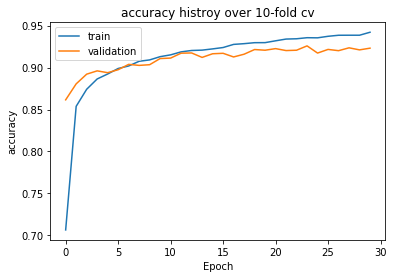

In [110]:
# plot accuracy history
plot_model_history([best_model_history['accuracy'], best_model_history['val_accuracy']],
                   legend=['train', 'validation'],
                   title='accuracy histroy over 10-fold cv',
                   ylabel='accuracy', xlabel='Epoch', figure_size=(6,4))

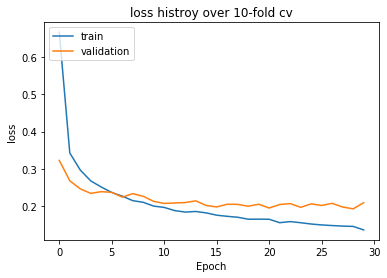

In [109]:
# plot loss history
plot_model_history([best_model_history['loss'], best_model_history['val_loss']],
                   legend=['train', 'validation'],
                   title='loss histroy over 10-fold cv',
                   ylabel='loss', xlabel='Epoch', figure_size=(6,4))

#### Saves

In [106]:
# Save all the history values for each grid_search combination to evalaute with bokeh.
save_models_history(param_list, models_history)

## Test

In [10]:
model = NN_model(hidden_layer_size=2, activation='relu', node_size=100, optimizer='adam')
history = model.fit(X_train, y_train, epochs=30, verbose=0)

In [11]:
classes = ['Walking', 'Upstairs', 'Downstairs', 'Sitting', 'Standing', 'Laying'] 
y_pred = model.predict_classes(X_test, verbose=0)

In [12]:
print(classification_report(y_pred, y_test, target_names=classes))

              precision    recall  f1-score   support

     Walking       0.94      0.87      0.90       541
    Upstairs       0.78      0.85      0.82       432
  Downstairs       0.86      0.88      0.87       412
     Sitting       0.61      0.91      0.73       329
    Standing       0.94      0.72      0.82       696
      Laying       1.00      1.00      1.00       537

    accuracy                           0.86      2947
   macro avg       0.86      0.87      0.86      2947
weighted avg       0.88      0.86      0.86      2947



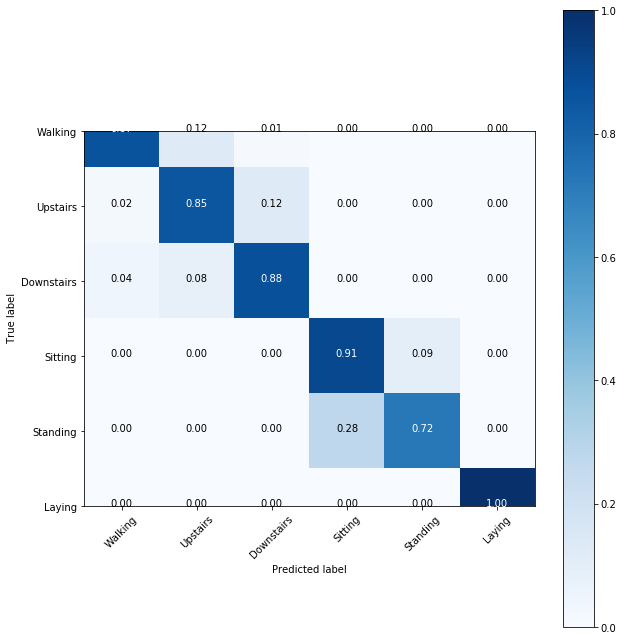

In [15]:
import itertools
plot_confusion_matrix(confusion_matrix(y_pred, y_test), classes, 'Predicted label',' True label', normalize=True)